## SD211_TP1
### GUO_Lieqiang

In [175]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from numpy.linalg import norm, pinv, inv
from scipy.sparse.linalg import svds
from scipy.optimize import check_grad
from scipy import sparse 
from scipy.optimize import fmin_cg

In [1]:
%matplotlib inline
%load_ext cythonmagic

D:\ProgramData\Anaconda3\lib\site-packages\IPython\extensions\cythonmagic.py:21: UserWarning: The Cython magic has been moved to the Cython package
  warnings.warn("""The Cython magic has been moved to the Cython package""")


### Functions

In [177]:

def load_movielens(filename, minidata=False):
    """
    Cette fonction lit le fichier filename de la base de donnees
    Movielens, par exemple 
    filename = '~/datasets/ml-100k/u.data'
    Elle retourne 
    R : une matrice utilisateur-item contenant les scores
    mask : une matrice valant 1 si il y a un score et 0 sinon
    """

    data = np.loadtxt(filename, dtype=int)

    R = sparse.coo_matrix((data[:, 2], (data[:, 0]-1, data[:, 1]-1)),
                          dtype=float)
    R = R.toarray()  # not optimized for big data

    # code la fonction 1_K
    mask = sparse.coo_matrix((np.ones(data[:, 2].shape),
                              (data[:, 0]-1, data[:, 1]-1)), dtype=bool )
    mask = mask.toarray()  # not optimized for big data

    if minidata is True:
        R = R[0:100, 0:200].copy()
        mask = mask[0:100, 0:200].copy()

    return R, mask


def objectiveP(P, Q0, R, mask, rho):
    """
    La fonction objectif du probleme simplifie.
    Prend en entree 
    P : la variable matricielle de taille C x I
    Q0 : une matrice de taille U x C
    R : une matrice de taille U x I
    mask : une matrice 0-1 de taille U x I
    rho : un reel positif ou nul

    Sorties :
    val : la valeur de la fonction
    grad_P : le gradient par rapport a P
    """

    tmp = (R - Q0.dot(P)) * mask

    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q0 ** 2) + np.sum(P ** 2))

    grad_P = - np.transpose(Q0).dot(tmp) + rho*P #todo

    return val, grad_P

def objectiveQ(P0, Q, R, mask, rho):
    """
    La fonction objectif du probleme simplifie.
    Prend en entree 
    P0 : la variable matricielle de taille C x I
    Q : une matrice de taille U x C
    R : une matrice de taille U x I
    mask : une matrice 0-1 de taille U x I
    rho : un reel positif ou nul

    Sorties :
    val : la valeur de la fonction
    grad_Q : le gradient par rapport a Q
    """

    tmp = (R - Q.dot(P0)) * mask

    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q ** 2) + np.sum(P0 ** 2))

    grad_Q = - tmp.dot(np.transpose(P0)) + rho*Q #todo

    return val, grad_Q

 
def total_objective(P, Q, R, mask, rho):
    """
    La fonction objectif du probleme complet.
    Prend en entree 
    P : la variable matricielle de taille C x I
    Q : la variable matricielle de taille U x C
    R : une matrice de taille U x I
    mask : une matrice 0-1 de taille U x I
    rho : un reel positif ou nul

    Sorties :
    val : la valeur de la fonction
    grad_P : le gradient par rapport a P
    grad_Q : le gradient par rapport a Q
    """

    tmp = (R - Q.dot(P)) * mask

    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q ** 2) + np.sum(P ** 2))

    grad_P = - np.transpose(Q).dot(tmp) + rho*P  # todo

    grad_Q = - tmp.dot(np.transpose(P)) + rho*Q  # todo

    return val, grad_P, grad_Q


def total_objective_vectorized(PQvec, R, mask, rho):
    """
    Vectorisation de la fonction precedente de maniere a ne pas
    recoder la fonction gradient
    """

    # reconstruction de P et Q
    n_items = R.shape[1]
    n_users = R.shape[0]
    F = PQvec.shape[0] / (n_items + n_users)
    Pvec = PQvec[0:n_items*F]
    Qvec = PQvec[n_items*F:]
    P = np.reshape(Pvec, (F, n_items))
    Q = np.reshape(Qvec, (n_users, F))

    val, grad_P, grad_Q = total_objective(P, Q, R, mask, rho)
    return val, np.concatenate([grad_P.ravel(), grad_Q.ravel()])


def gradient_lineal_Q(objectiveQ, P0, Q0, R, mask, epsilon, fig=False):
    """search the optimal Q when P is fixed"""
    
    k = 1
    
    Qold = Q0
    
    val, grad_Q = objectiveQ(P0, Qold, R, mask, rho)
    
    vals = []
    
    vals.append(val)
    
    while(np.sqrt(np.sum(grad_Q*grad_Q)) > epsilon):
        
        k = k + 1
                  
        n1 = -rho*np.sum(grad_Q*Qold) + np.sum((grad_Q.dot(P0)*(R - Qold.dot(P0))*mask))
        
        n2 = np.sum((grad_Q.dot(P0)*mask)**2) + rho*np.sum((grad_Q)**2)
        
        t = n1/n2
        
        Qnew = Qold + t*grad_Q
        
        Qold = Qnew
        
        val, grad_Q = objectiveQ(P0, Qold, R, mask, rho)
        
        vals.append(val)
    
    if(fig):
        plt.figure()
        plt.plot(vals)
        plt.title("line search while P is fixed")
        plt.show()
    
    return val, Qold

## Introduction of project

### Question 1.1
#### Load data

In [178]:
filename = './ml-100k/u.data'

R1, mask1 = load_movielens(filename, minidata=True)
Q1, s1, P1 = svds(R1)
print("when minidata is True, the size of R1 is (%d, %d)"%(R1.shape[0], R1.shape[1]))

R2, mask2 = load_movielens(filename, minidata=False)
Q2, s2, P2 = svds(R2)

print("when minidata is True, the size of R2 is (%d, %d)"%(R2.shape[0], R2.shape[1]))

when minidata is True, the size of R1 is (100, 200)
when minidata is True, the size of R2 is (943, 1682)


##### The option minidata is for reducing the scale of problem.

### Question 1.2

In [179]:
print("The nomber of users is %d"%(R2.shape[0]))
print("The nomber of films is %d"%(R2.shape[1]))
print("The nomber of notes is %d"%(np.sum(R2 != 0)))

The nomber of users is 943
The nomber of films is 1682
The nomber of notes is 100000


### Question 1.3

The object function is not convex. For a special case, as we can see from the following graph, we don't have a global minimum! The gradient $[\nabla_P, \;\nabla_Q]$ is $[-Q^T(R-QP) + rho*P, \;-(R-QP)P^T + rho*Q]$. It's not lipschitzien.

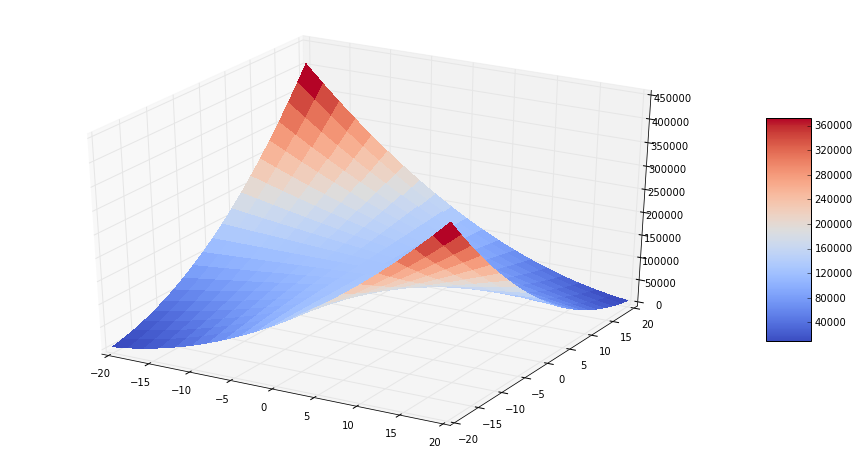

In [180]:
rho = 0.2

fig = plt.figure(figsize=(16, 8))

ax = fig.gca(projection='3d')

x = np.linspace(-20, 20, 200)
y = np.linspace(-20, 20, 200)
xx, yy = np.meshgrid(x,y)

zz = (500.0 - xx*yy)**2/2.0 +  rho/2.0*(xx**2 + yy**2)

# Plot the surface.
surf = ax.plot_surface(xx, yy, zz, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### Question 2.1

The fonction g, its gradient $\nabla g(P) $ is $-Q0^T*R + (rho*I + Q0^T*Q0)*P$, and ${\nabla}^2 g(P)$ is $ (rho*I + Q0^T*Q0)$, because ${\nabla}^2 g(P)$ is definitely prositive. So it's convex.

### Question 2.2

In [184]:
def funcCheck(Pv, P, Q, R, mask, rho):
    
    
    P0 = np.reshape(Pv, P.shape)
    
    tmp = (R - Q.dot(P0)) * mask
    
    return np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q ** 2) + np.sum(P0 ** 2))


def grad(Pv, P0, Q0, R, mask, rho):
    
    P = np.reshape(Pv, P0.shape)
    
    tmp = (R - Q0.dot(P)) * mask

    grad_P = - np.transpose(Q0).dot(tmp) + rho*P    

    return grad_P.ravel()                            

rho = 0.2

print("The difference is %.4lf"%check_grad(funcCheck, grad, P2.ravel(), P2, Q2, R2, mask2, rho))

The difference is 1.2064


### Question 2.3

In [182]:
def gradient(objectiveP, P0, gamma, epsilon):
    
    Pold = P0
    
    val, grad_P = objectiveP(Pold, Q2, R2, mask2, rho)
    
    vals = []
    
    vals.append(val)
    
    Pnew = Pold - gamma*grad_P
    
    while((np.sqrt(np.sum(grad_P*grad_P))) > epsilon):
        
        Pold = Pnew
        
        val, grad_P = objectiveP(Pold, Q2, R2, mask2, rho)
        
        vals.append(val)
        
        Pnew = Pold - gamma*grad_P
    
    plt.figure()
    plt.plot(vals)
    plt.title("using gradient method with step fixed")
    plt.show()
    return val, Pold

### Question 2.4

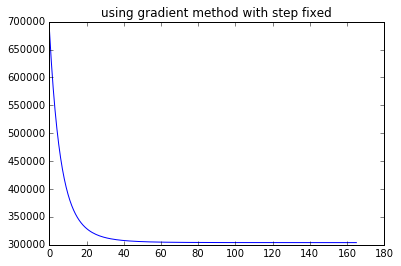

the minimal value of g is 303938.4250


In [183]:
epsilon = 1.0

rho = 0.2

gamma = 0.10

val, P_min = gradient(objectiveP, P2, gamma, epsilon)

print("the minimal value of g is %.4lf"%val)

### Question 3.1

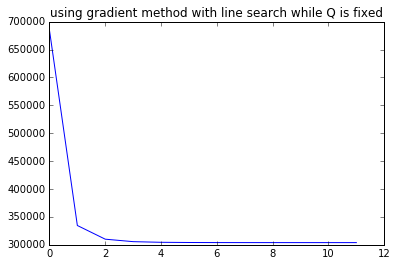

the minimal value of g is 303937.2499


In [190]:
def gradient_lineal_P(objectiveP, P0, Q0, R, mask, epsilon, fig=False):
    """search the optimal P when Q0 is fixed"""
    k = 1
    
    Pold = P0
    
    val, grad_P = objectiveP(Pold, Q0, R, mask, rho)
    
    vals = []
    
    vals.append(val)
    
    while(np.sqrt(np.sum(grad_P*grad_P)) > epsilon):
        
        k = k + 1
                  
        n1 = -rho*np.sum(grad_P*Pold) + np.sum((Q0.dot(grad_P)*(R - Q0.dot(Pold))*mask))
        
        n2 = np.sum((Q0.dot(grad_P)*mask)**2) + rho*np.sum((grad_P)**2)
        
        t = n1/n2
        
        Pnew = Pold + t*grad_P
        
        Pold = Pnew
        
        val, grad_P = objectiveP(Pold, Q0, R, mask, rho)
        
        vals.append(val)
        
    if(fig):
        plt.figure()
        plt.plot(vals)
        plt.title("using gradient method with line search while Q is fixed")
        plt.show()
    
    return val, Pold

val, P_min = gradient_lineal_P(objectiveP, P2, Q2, R2, mask2, epsilon, fig=True)

print("the minimal value of g is %.4lf"%val)

### Question 3.2
#### here we define some new variables:

$X = P.ravel('F') = \begin{Bmatrix}
        P_{1,1} \\
        P_{2,1} \\
        \vdots \\
        P_{C-1,I} \\
        P_{C,I} \\
 \end{Bmatrix}$

$Qm_{(U*I)*(C*I)} = \begin{Bmatrix}
    Q & 0 & \cdots & 0 \\
    0 & Q & \cdots & 0 \\
    \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \cdots & Q \\
 \end{Bmatrix} $
 
$Y = R.ravel('F') = \begin{Bmatrix}
    R_{1,1} \\
    R_{2,1} \\
    \vdots \\
    R_{U-1,I} \\
    R_{U,I} \\
 \end{Bmatrix}$

$M = np.diag(mask.ravel('F')) = \begin{Bmatrix}
    m_{1,1} & 0 & \cdots & 0 \\
    0 & m_{2,1} & \cdots & 0 \\
    \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \cdots & m_{U,I} \\
 \end{Bmatrix}$

#### Next the function $g(P)$ can be rewrited as a function $f(X)$:

$ g(X) = \frac{1}{2}*(1_K \circ ||R-Q_0P||_F^2) + \frac{\rho}{2}*(||P||_F^2 + ||Q_0||_F^2 )$

$ f(X) = \frac{1}{2}(M*(Y - QmX))^T*(M*(Y - QmX)) + \frac{\rho}{2}*(X^TX) + \frac{\rho}{2}*(||Q_0||_F^2)$

$ = \frac{1}{2}(X^TQm^TM^TMQmX - 2* Y^TM^TMQmX + Y^TM^TMY) + \frac{\rho}{2}*(X^TX) + \frac{\rho}{2}*(||Q_0||_F^2)$

$ = \frac{1}{2}(X^T(Qm^TM^TMQm + \rho*Id)X) - Y^TM^TMQmX + Y^TM^TMY + \frac{\rho}{2}*(||Q_0||_F^2)$

$Id$ is a identity matrix, and its shape is $(C*I)*(C*I)$.

#### if we define:

$ A = (Qm^TM^TMQm + \rho*Id)$ 

$ b^T = - Y^TM^TMQm$

$ c = Y^TM^TMY + \frac{\rho}{2}*(||Q_0||_F^2)$


#### then:

$f(X) =  \frac{1}{2}(X^TAX) + b^TX + c$

#### A is positive! so we can use conjugate gradient method to solve the problem $f(X)$. That is to say we can use conjugate gradient method to solve the problem $g(P)$

In [188]:
""" conjugate gradient method """

def gradient_cg(objectiveX, P, Q, R, mask, rho, epsilon, fig=False):
    
    val, grad_X = objectiveX(P, Q, R, mask, rho)
    np.sum
    g0 = grad_X
    
    d0 = - grad_X
    
    s0 = - np.sum(d0*g0)/(np.sum(d0*(np.transpose(Q).dot(Q.dot(d0)*mask))) + rho*np.sum(d0*g0))
    
    x1 = P + s0*d0
    
    vals = []
    
    vals.append(val)
    
    while(np.sqrt(np.sum(grad_X*grad_X)) > epsilon):
        
        val, grad_X = objectiveX(x1, Q, R, mask, rho)
        
        g1 = grad_X
        
        b1 = np.sum(d0*(np.transpose(Q).dot(Q.dot(g1)*mask)))/np.sum(d0*(np.transpose(Q).dot(Q.dot(d0)*mask)))
        
        d0 = - g1 + b1*d0
        
        s1 = - np.sum(d0*g1)/np.sum(d0*(np.transpose(Q).dot(Q.dot(d0)*mask)))
        
        x1 = x1 + s1*d0
        
        vals.append(val)
        
    if(fig):
        plt.figure()
        plt.plot(vals)
        plt.title("using conjugate gradient method")
        plt.show()
        
    return val, grad_X

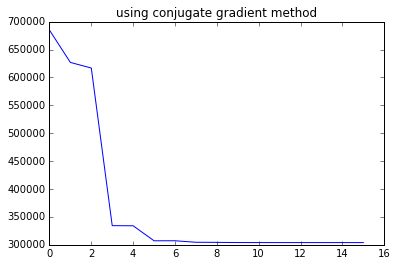

the minimal value of g is 303936.7504
Optimization terminated successfully.
         Current function value: 303936.821886
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18


In [189]:
val, grad_P = gradient_cg(objectiveP, P2, Q2, R2, mask2, rho, 1, fig=True)

print("the minimal value of g is %.4lf"%val)

info = fmin_cg(funcCheck, P2.ravel(), fprime=grad, args=(P2, Q2, R2, mask2, rho), gtol=1.0, norm=2.0, retall=False)

#### To solve the problem $g(Q)$

$g(Q) = (\frac{1}{2}*(1_K \circ ||R-QP_0||_F^2) + \frac{\rho}{2}*(||P_0||_F^2 + ||Q||_F^2)$

$ = (\frac{1}{2}*(1_K^T \circ ||R^T- P_0^TQ^T||_F^2) + \frac{\rho}{2}*(||P_0||_F^2 + ||Q^T||_F^2)$

if we note $R = R^T, Q = P_0^T, P = Q^T, mask = mask^T$

we can use the function objectiveP to solve the problem!

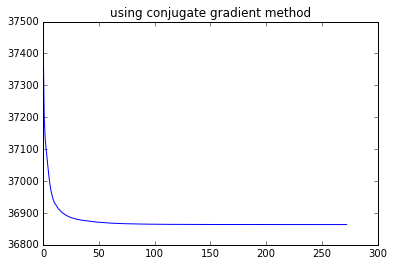

the minimal value of g is 36863.4967
Optimization terminated successfully.
         Current function value: 36863.531887
         Iterations: 340
         Function evaluations: 512
         Gradient evaluations: 512


In [159]:
""" we can use the solver gradient_cg_P of problem g(P) to solve the problem of g(Q) by just changing the args """

val, grad_QT = gradient_cg(objectiveP, Q2.T, P2.T, R2.T, mask2.T, rho, 1, fig=True)

print("the minimal value of g is %.4lf"%val)

val = fmin_cg(funcCheck, Q2.T.ravel(), fprime=grad, args=(Q2.T, P2.T, R2.T, mask2.T, rho), gtol=1.0, norm=2.0, retall=False)

### Question 3.3

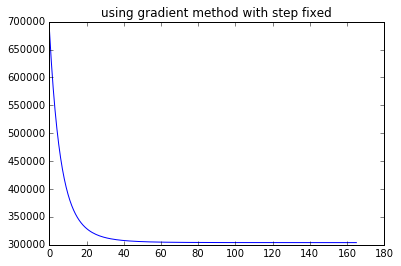

Using gradient with constant step, the minimal value of g is 303938.4250


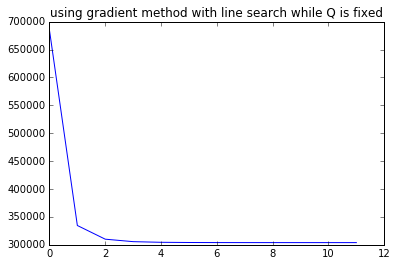

Using gradient lineal search, the minimal value of g is 303937.2499


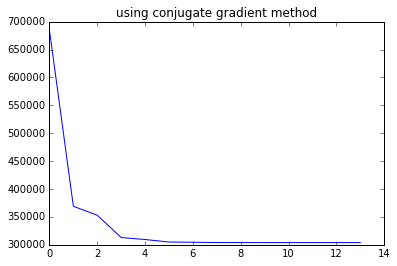

Using conjugate gradient method, the minimal value of g is 303936.6317


In [185]:
val, P_min = gradient(objectiveP, P2, gamma, epsilon)

print("Using gradient with constant step, the minimal value of g is %.4lf"%val)

val, P_min = gradient_lineal_P(objectiveP, P2, Q2, R2, mask2, epsilon, fig=True)

print("Using gradient lineal search, the minimal value of g is %.4lf"%val)

val, grad_P = gradient_cg(objectiveP, P2, Q2, R2, mask2, rho, 1, fig=True)

print("Using conjugate gradient method, the minimal value of g is %.4lf"%val)

#### As we can see, the slowest method is gradient method with constant step, the fastest and the most accurate method is the conjugate gradient method. The performance of gradient with lineal search is between gradient method with constant step and conjugate gradient method.

### Question 4.1

In [243]:
def solu_gl(P, Q, R, mask, epsilon):
        
    valP, P_min = gradient_lineal_P(objectiveP, P, Q, R, mask, epsilon)
    
    valQ, Q_min = gradient_lineal_Q(objectiveQ, P_min, Q, R, mask, epsilon)
    
    k = 1
    
    while(True):
        
        k = k + 1
        
        valP, P_min = gradient_lineal_P(objectiveP, P_min, Q_min, R, mask, epsilon)
        
        valQ, Q_min = gradient_lineal_Q(objectiveQ, P_min, Q_min, R, mask, epsilon)
        
        if(k > 20):
             break
        
    return valQ, P_min, Q_min

In [244]:
val, P_min, Q_min = solu_gl(np.ones(P2.shape), np.ones(Q2.shape), R2, mask2, 100)

print("the minimal value of g is %.4lf"%val)   

the minimal value of g is 43082.0256


### Question 4.2
 $for \; k \geq 1 \,do$

$Pk = argmin_P(\frac{1}{2}*(1_K \circ ||R-Q_{k-1}P||_F^2) + \frac{\rho}{2}*(||P||_F^2 + ||Q_{k-1}||_F^2)$

$Qk = argmin_Q(\frac{1}{2}*(1_K \circ ||R-QP_k||_F^2) + \frac{\rho}{2}*(||P_k||_F^2 + ||Q||_F^2)$

$end \; for$

In this algorithm, we can see that g(P) and g(Q) are both convexe, so we in each step, the value of $(\frac{1}{2}*(1_K \circ ||R-QP||_F^2) + \frac{\rho}{2}*(||P||_F^2 + ||Q||_F^2)$ decreases. But the value has to greater than 0, so the it convergents to a certain value! However, we can only get the local minimum value, because the funtion $(\frac{1}{2}*(1_K \circ ||R-QP||_F^2) + \frac{\rho}{2}*(||P||_F^2 + ||Q||_F^2)$ is not convexe.

code

$Pk_i = (Q_{k-1}^TM_iQ_{k-1} + \rho*Id)^{-1}Q_{k-1}^T(R_i*M_i)$

for Q, we can use the solver to P.

### Question 4.3

In [246]:
def algoMC(P, Q, R, mask, rho):
    
    Pnew = P
    
    cols = P.shape[1]
    
    for i in range(cols):        
                
        tmp = inv(((Q.T).dot(np.diag(mask[:,i]))).dot(Q) + rho*np.identity(Q.shape[1]))
        
        Pnew[:,i] = tmp.dot(Q.T.dot(np.diag(mask[:,i]))).dot(R[:,i])
    
    tmp = (R - Q.dot(Pnew)) * mask
    
    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q ** 2) + np.sum(Pnew ** 2)) 
    
    return val, Pnew

In [247]:
def solution_algoMC(P, Q, R, mask, rho, epsilon):
        
    valP, P_min = algoMC( P, Q, R, mask, epsilon)
    
    valQ, Q_minT = algoMC(Q.T, P_min.T, R.T, mask.T, epsilon)
    
    k = 1
    
    while(True):
        
        k = k + 1
        
        valP, P_min = algoMC(P_min, Q_minT.T, R, mask, epsilon)
        
        valQ, Q_minT = algoMC(Q_minT, P_min.T, R.T, mask.T, epsilon)
        
        if(k>20):
            
            break
            
    return valQ, P_min, Q_minT.T

### Question 4.4

In [253]:
import timeit

start = timeit.default_timer()

#Your statements here
val, P_min, Q_min = solu_gl(np.ones(P2.shape), np.ones(Q2.shape), R2, mask2, 100)

stop = timeit.default_timer()

print("run time %.4lf seconds, using gradient with lineal search, the minimal value of g is %.4lf" %(stop - start, val))   

start = timeit.default_timer()

val, P, Q = solution_algoMC(np.ones(P2.shape), np.ones(Q2.shape), R2, mask2, rho, epsilon)

stop = timeit.default_timer()

print("run time %.4lf seconds, using least square method, the minimal value of g is %.4lf" %(stop - start, val))

run time 7.8051 seconds, using gradient with lineal search, the minimal value of g is 43082.0256
run time 254.6604 seconds, using least square method, the minimal value of g is 34876.2715


#### solutions are not the same. the prediction $R' = QP$ is not the same, the value is not the same. And least square method spends more time to calculate, and the gradient with line search needs less time to run.

### Question 4.5

In [254]:
resLS = np.argmax((Q_min[449,:].dot(P_min))*(1 - mask2[449,:]))

resMC = np.argmax((Q[449,:].dot(P))*(1 - mask2[449,:]))

print(resLS)
print(resMC)

1535
1448


#### according to gradient with line search method, I will recommend the user 449 the film 1535
#### according to least square method method, I will recommend the user 449 the film 1448